In [404]:
# Imports from the helpers folder, containing the lstm code and auxilliary functions
import sys  
sys.path.insert(0, "helpers/")
from lstm import Model, Optimization
from aux_functions import (dateindex_from_weeknum, dateindex_from_timestamp, ts_train_test_split, 
                           cols_with_most_corr, lagged_corr, lagged_corr_matrix, 
                           cols_with_most_lagged_corr, calculate_pvalues, cols_with_sig_pval, corr_feature_selection)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pltio
import statsmodels.api as sm
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency, kruskal
# Packages of forecasting models
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive, drift, mean, seasonal_naive)
import pmdarima as pm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load data

In [372]:
# Turin daily sales data
turin_data_df = pd.read_csv("../datasets/turin_daily.csv", index_col=[0], parse_dates=True)
print("Turin sales data:", turin_data_df.shape)
print(turin_data_df.head())
print("\n")

# Exogenous weather data
parser = lambda date: datetime.strptime(date, '%d/%m/%Y')
turin_weather_df = pd.read_csv("../datasets/Eso_data/weather/torino_weather_data.csv", index_col=[1], parse_dates=True, date_parser=parser)

Turin sales data: (1460, 1)
            qty
time           
2016-01-02  127
2016-01-03  105
2016-01-04   86
2016-01-05  213
2016-01-06  299




In [373]:
def augment_store_data (store_df, loc_weather_df):
    store_daily_totals = store_df

    # Check for NAN values in sales and replace them if they are present
    sales_nan_indices = store_daily_totals[store_daily_totals.isnull().any(axis=1)].index
    for nan_idx in sales_nan_indices:
        n_days_ago = nan_idx - timedelta(days=1)
        store_daily_totals.loc[nan_idx, "qty"] = np.mean(store_daily_totals.loc[n_days_ago:nan_idx,"qty"].values)
    
    ## WEATHER DATA
    
    # We won't be using the following cols (nan vals or categorical)
    loc_weather_df = loc_weather_df.drop(["LOCALITA", "PRESSIONEMEDIA mb", "PIOGGIA mm"], axis=1)
    loc_weather_df = loc_weather_df.loc[store_daily_totals.index[0]:,:]

    # Check for NAN values in sales and replace them if they are present
    #weather_nan_indices = loc_weather_df[loc_weather_df.isnull().any(axis=1)].index
    #print(weather_nan_indices)
    #for nan_idx in weather_nan_indices:
    #    for col in loc_weather_df:
    #        n_days_after = nan_idx + timedelta(days=2)
    #        loc_weather_df.loc[nan_idx, col] = np.mean(loc_weather_df.loc[nan_idx:n_days_after, col])
    
    # Here we add exogenous data we run the train the network with and without these new data. 
    # If the prediction improves then we are looking at leading indicator and better forecast accuracy.
    store_daily_weather_augmented = store_daily_totals.copy(deep=True)
    for w_col in loc_weather_df.columns:
        store_daily_weather_augmented[w_col] = loc_weather_df.loc[:, w_col]
   
    
    return store_daily_totals, store_daily_weather_augmented

# Augment single location sales data and then put everything together
turin_daily_default, turin_daily_augmented = augment_store_data(turin_data_df, turin_weather_df)
print("Turin data original shape:", turin_daily_default.shape)
print("Turin + exogenous data shape:", turin_daily_augmented.shape)

Turin data original shape: (1460, 1)
Turin + exogenous data shape: (1460, 12)


# Scenario 1:  Sales and day of the week

This scenario explores how the day of the week is connected to the amount of sold produts. If we were to take a sample of the data we could actually see the sales quantity is mostly higher on Fridays (day 5) or the weekend. Of course this does not hold when we have seasonal sales, but that will be explored later.

In [421]:
day_nr = np.array(list(map(int, turin_daily_augmented.index.strftime('%j').tolist())))
turin_daily_augmented["day_of_week"] = (day_nr+3)%7
turin_daily_augmented.iloc[205:220, [0,-1]]

,qty,day_of_week
time,,
2016-07-25,89,0
2016-07-26,96,1
2016-07-27,122,2
2016-07-28,117,3
2016-07-29,111,4
2016-07-30,157,5
2016-07-31,152,6
2016-08-01,116,0
2016-08-02,80,1


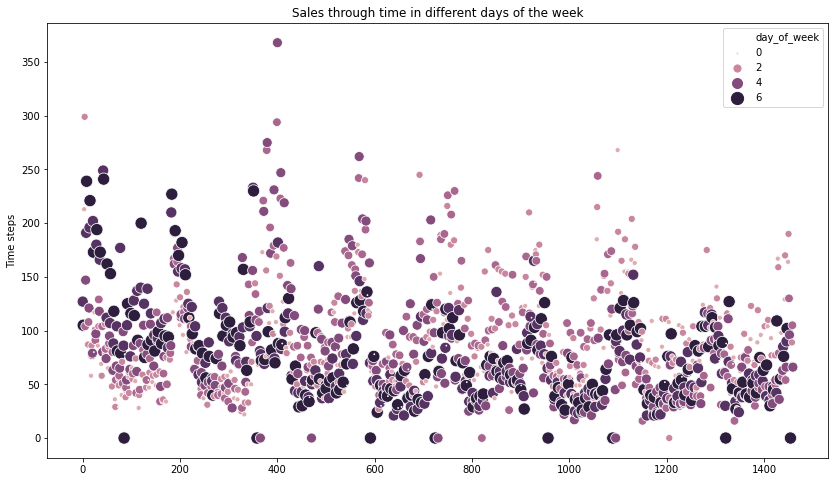

In [403]:
plt.figure(figsize=(14,8))
plt.title("Sales through time in different days of the week")
ax = sns.scatterplot(x=range(0, len(turin_daily_augmented)), y="qty", hue="day_of_week", size="day_of_week", sizes=(1, 150), data=turin_daily_augmented)
ax.set(ylabel="Time steps")
plt.show()

We can use a Kruskal-Wallis H-test, which tests the null hypothesis that the population medians of all of the groups are equal. It is a non-parametric version of ANOVA

In [407]:
kw_test = kruskal(turin_daily_augmented.qty, turin_daily_augmented.day_of_week)
print("Kruskal-Wallis H-test Test statistic:", kw_test[0])
print("Kruskal-Wallis H-test P-value:", kw_test[1])

Kruskal-Wallis H-test Test statistic: 2090.269684784118
Kruskal-Wallis H-test P-value: 0.0


# Scenario 2: Sales and holidays (seasonal sales)

Most people go shopping and buy more things when there are seasonal sales for holidays, e.g., Christmas. This will probably keep happening every year

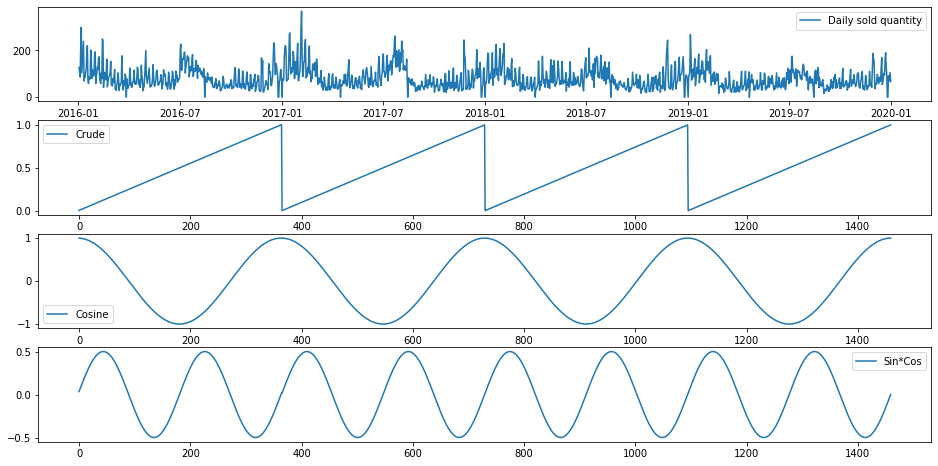

In [430]:
day_yearly_nr = np.array(list(map(int, turin_daily_augmented.index.strftime('%j').tolist())))
nrm_days = day_yearly_nr/365
sin_days = np.sin((day_yearly_nr/365) * 2*np.pi)
cos_days = np.cos((day_yearly_nr/365) * 2*np.pi)
sincos_days = sin_days*cos_days

plt.figure(figsize=(16,8))
plt.subplot(4, 1, 1)
plt.plot(turin_daily_augmented.qty, label="Daily sold quantity")
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(nrm_days, label="Crude")
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(cos_days, label="Cosine")
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(sincos_days, label="Sin*Cos")
plt.legend()
plt.show()

# Scenario 3: Sales and weather (exogenous variables)

In [351]:
# Nan (bello) = 2
# Solo Pioggia = -1
# Pioggia + extra = -2
# Resto = 1

turin_daily_augmented.FENOMENI.fillna(2, inplace=True)
turin_daily_augmented.FENOMENI.replace(to_replace=turin_daily_augmented.FENOMENI[turin_daily_augmented.FENOMENI == "pioggia "], value=-1, inplace=True)
pioggia_and_index = [True if (isinstance(fenomeno,str) and "pioggia" in fenomeno) else False for fenomeno in turin_daily_augmented.FENOMENI.values]
turin_daily_augmented.FENOMENI.replace(to_replace=turin_daily_augmented.FENOMENI[pioggia_and_index], value=-2, inplace=True)
the_others = [True if (isinstance(fenomeno,str)) else False for fenomeno in turin_daily_augmented.FENOMENI.values]
turin_daily_augmented.FENOMENI.replace(to_replace=turin_daily_augmented.FENOMENI[the_others], value=1, inplace=True)
turin_daily_augmented

In [362]:
m=15
qty_roll_mean = turin_daily_augmented.qty.rolling(window=m).mean()
mean_first_m = np.mean(turin_daily_augmented.iloc[:15, 0])
full_roll_mean = qty_roll_mean.fillna(mean_first_m)

new_signal_vals = [1 if val > full_roll_mean[idx] else -1 for idx, val in enumerate(turin_daily_augmented.qty.values)]
turin_daily_augmented["meanlbl"] = new_signal_vals
turin_daily_augmented["compatibility"] = turin_daily_augmented.FENOMENI * turin_daily_augmented.meanlbl
turin_daily_augmented

,qty,TMEDIA °C,TMIN °C,TMAX °C,PUNTORUGIADA °C,UMIDITA %,VISIBILITA km,VENTOMEDIA km/h,VENTOMAX km/h,RAFFICA km/h,PRESSIONESLM mb,FENOMENI,meanlbl,compatibility
time,,,,,,,,,,,,,,
2016-01-02,127,3.0,2.0,4.0,2.0,92.0,2.0,4.0,11.0,0.0,1018.0,-1,-1,1
2016-01-03,105,2.0,1.0,2.0,1.0,95.0,2.0,6.0,11.0,0.0,1009.0,1,-1,-1
2016-01-04,86,1.0,0.0,2.0,1.0,93.0,3.0,5.0,9.0,0.0,1000.0,-2,-1,2
2016-01-05,213,3.0,1.0,4.0,1.0,87.0,7.0,5.0,9.0,0.0,1000.0,2,1,2
2016-01-06,299,3.0,-1.0,8.0,1.0,80.0,12.0,5.0,11.0,0.0,1001.0,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,91,4.0,0.0,9.0,0.0,68.0,18.0,5.0,9.0,0.0,1022.0,2,-1,-2
2019-12-28,69,3.0,-1.0,10.0,2.0,79.0,14.0,5.0,11.0,0.0,1030.0,2,-1,-2
2019-12-29,89,3.0,0.0,8.0,2.0,84.0,7.0,5.0,9.0,0.0,1033.0,2,-1,-2


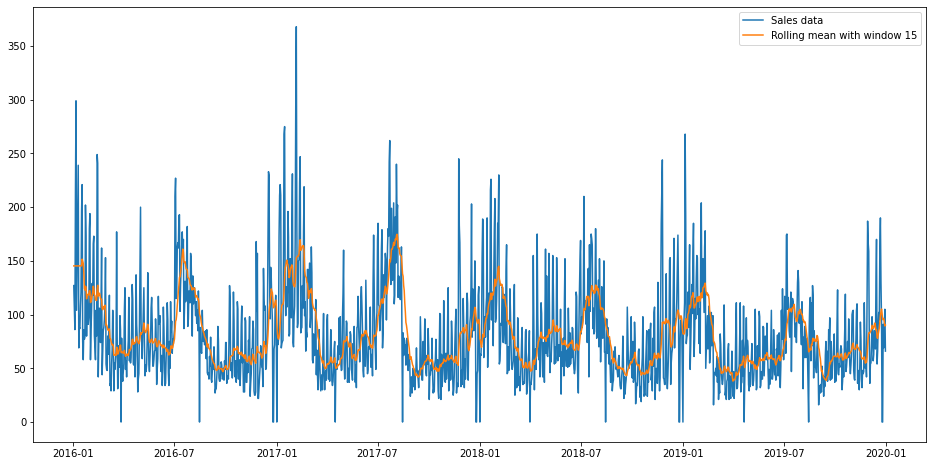

In [363]:
plt.figure(figsize=(16,8))
plt.plot(turin_daily_augmented.qty, label="Sales data")
plt.plot(full_roll_mean, label="Rolling mean with window "+str(m)) 
plt.legend()
plt.show()

In [364]:
# Chi-sq and contingency table for the weather phenomena and the mean amount of bought products
ctg_matrix = pd.crosstab(turin_daily_augmented["meanlbl"], turin_daily_augmented["FENOMENI"])
ctg_matrix

FENOMENI,-2,-1,1,2
meanlbl,,,,
-1,136,147,57,514
1,110,115,45,336


In [207]:

# Good weather (no phenomena) makes you more likely to "not buy" (qty under the mean) than bad weather.
# Gotta check the mean condition here aka the rolling mean 

FENOMENI,-2,-1,1,2
meanlbl,,,,
-1,134,145,59,516
1,112,117,43,334


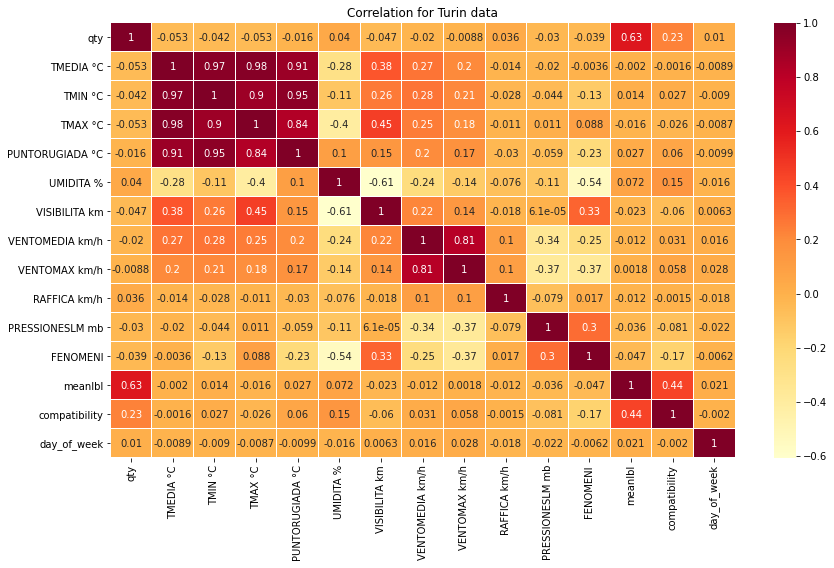

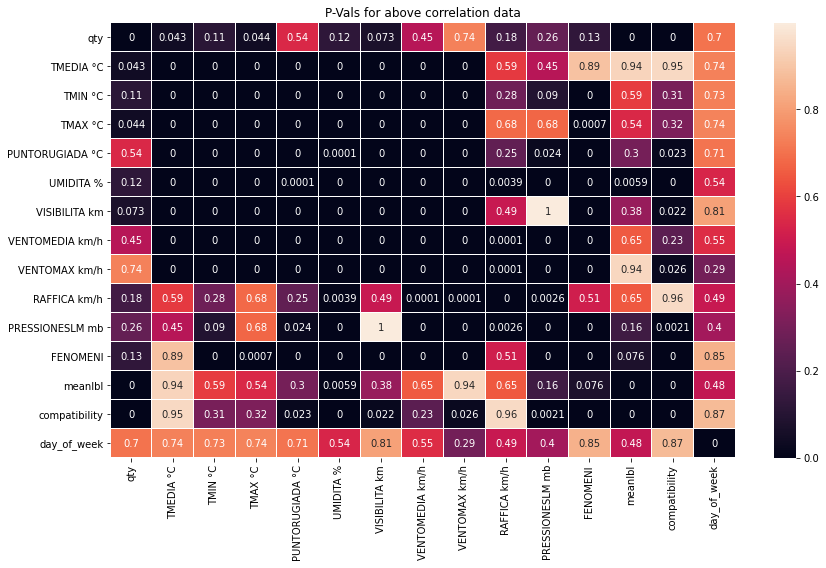

In [366]:
# Correlation in the data with added exogenous variables: Spearman Correlation
default_s_corr = turin_daily_augmented.corr(method="spearman")
plt.figure(figsize=(14,8))
sns.heatmap(data=default_s_corr, cmap="YlOrRd", annot=True, linewidths=.1)
plt.title("Correlation for "+ dataset+" data")
plt.show()

def_p_val_matrix = calculate_pvalues(turin_daily_augmented, lag=0)
plt.figure(figsize=(14,8))
sns.heatmap(data=def_p_val_matrix, annot=True, linewidths=.1)
plt.title("P-Vals for above correlation data")
plt.show()

In [247]:
from sklearn.metrics import adjusted_mutual_info_score

mis_matrix = np.zeros(shape=(len(turin_daily_augmented.columns), len(turin_daily_augmented.columns)))
for i in range(0,mis_matrix.shape[0]):
    for j in range(0, mis_matrix.shape[1]):
        print(i,j)
        mis_matrix[i][j] = adjusted_mutual_info_score(turin_daily_augmented.iloc[:,i].values, turin_daily_augmented.iloc[:,j].values)

0 0
0 1
0 2
0 3
0 4


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# LSTM helper functions

In [69]:
def build_in_out_seq(tr_df, te_df, desired_input_features, in_len, out_len):
    # Building the NN input and outputs. LSTM will expect a supervised learning problem, hence we need to build
    # input sequences that will have output sequences which the model will then learn.
    
    # Training
    inp_tr = np.stack([tr_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_tr = np.stack([tr_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    # Testing
    inp_te = np.stack([te_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_te = np.stack([te_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    print("Inputs for training")
    print(inp_tr.shape)
    print("Outputs for training")
    print(out_tr.shape)
    print("Inputs for testing")
    print(inp_te.shape)
    print("Outputs for testing")
    print(out_te.shape)
    print("\n")

    return inp_tr, out_tr, inp_te, out_te

In [71]:
def prepare_for_network(train, test, input_features, in_len, out_len):
    # Build the full training and testing dataframes
    # In order to pass the data to the LSTM we need to transform it so it is in the range [0,1]
    # We scale all our data in order to build the final training and test dataframes
    tr_df = train.copy(deep=True)
    te_df = test.copy(deep=True)
    
    for col in tr_df.columns:
        # Z standartization
        mean = np.mean(train.loc[:,col].values)
        std = np.std(train.loc[:,col].values)
        
        tr_df.loc[:, col] = (train.loc[:,col].values-mean)/std
        te_df.loc[:, col] = (test.loc[:,col].values-mean)/std


    inp_tr, out_tr, inp_te, out_te = build_in_out_seq(tr_df, pd.concat([tr_df.iloc[-in_len:, :], te_df]), input_features, in_len, out_len)
    return inp_tr, out_tr, inp_te, out_te

In [40]:
def define_LSTM_Model(input_features):
    loss_fn = nn.MSELoss()
    LSTM_Model = Model(input_size=len(input_features), hidden_size=20 + len(input_features)*5, output_size=len(input_features))
    optimizer = optim.Adam(LSTM_Model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=25, gamma=0.1)
    opt_obj = Optimization(LSTM_Model, loss_fn, optimizer, scheduler)
    return LSTM_Model, opt_obj

In [41]:
def check_lstm_forecast_results(pred, inp_te, out_te, poll_mean, poll_std, in_len, out_len):
    # *Data back needs to rescaled back to normal*
    pred_vec = (pred[0,-out_len:,0].detach().cpu().numpy() * poll_std) + poll_mean
    real_vec = (out_te[0,:,0] * poll_std) + poll_mean
    rmse = sm.tools.eval_measures.rmse(pred_vec, real_vec)
    mae = sm.tools.eval_measures.meanabs(pred_vec, real_vec)
    
    return rmse, mae

In [208]:
def ts_train_test_split_new(df, test_length=0.2):
    # Perform train-test split
    split_index = int(df.shape[0]*test_length)
    train = df[:-split_index]
    test = df[-split_index:]    
    return train, test

# Forecasting evaluation

In [212]:
single_run_results = []
n_runs = 3

for dataset in aug_datasets:
    print("Running forecasting for sales in", dataset)
    for run in range(n_runs):
        print ("Run #", run+1)
        # Load the default and augmented versions of the data
        aug_dataset = aug_datasets[dataset]
        def_dataset = def_datasets[dataset]
        print(def_dataset.shape)

        # Create training and test data
        def_train, def_test = ts_train_test_split_new(def_dataset, test_length=0.1)
        aug_train, aug_test = ts_train_test_split_new(aug_dataset, test_length=0.1)
        print(def_train.shape, def_test.shape, aug_train.shape, aug_test.shape)
        
        print(def_train.head())
        print(def_train.tail())
        print(def_test, "\n\n")
        

        # Extract the columns which display most correlation with the value we are trying to predict.
        def_desired_input_features = corr_feature_selection(def_train)
        aug_desired_input_features = corr_feature_selection(aug_train)
        all_poss_features = list(range(0, len(aug_train.columns)))
        print("Default input features:", def_desired_input_features)
        print("Input features with selected exogenous data:", aug_desired_input_features)
        print("Input features with all exogenous data:", all_poss_features)
        print()
        
        # sin cos     
        day_nr = np.array(list(map(int, store_daily_totals.index.strftime('%j').tolist())))
        store_daily_totals["sin_day"] =  np.sin((day_nr/365) * 2*np.pi)
        store_daily_totals["cos_day"] = np.cos((day_nr/365) * 2*np.pi)
        store_daily_totals["sincos_day"] = np.sin((day_nr/365) * 2*np.pi) * np.cos((day_nr/365) * 2*np.pi)
        store_daily_totals["sin_weekday"] =  np.sin((day_nr/7) * 2*np.pi)
        store_daily_totals["cos_weekday"] = np.cos((day_nr/7) * 2*np.pi)
        store_daily_totals["sincos_weekday"] = np.sin((day_nr/7) * 2*np.pi) * np.cos((day_nr/7) * 2*np.pi)
        
        ## Run STL Decomposition as baseline
        #print("Running Drift model based on STL Decomposition...")
        #f_steps = def_test.shape[0]
        #decomp = decompose(def_train.qty, period=52)
        #drift_forecast = forecast(decomp, steps=f_steps, fc_func=drift)
        #drift_rmse = sm.tools.eval_measures.rmse(def_test.qty.values, drift_forecast["drift"].values)
        #drift_mae = sm.tools.eval_measures.meanabs(def_test.qty.values, drift_forecast["drift"].values)
        #print("Done\n")
        #
        ## Run ARIMA as another baseline
        #print("Running ARIMA model...")
        ## Fit your model
        #arima_model = pm.auto_arima(def_train.qty, suppress_warnings=True, max_order=None, \
        #                            start_p=3, start_q=0, start_P=0, start_Q=0, \
        #                            max_p=6, max_d=1, max_q=1, max_P=1, max_D=1, max_Q=1)
        #arima_order = arima_model.get_params()["order"]
        #arima_fitted = arima_model.fit(def_train.qty)
        #arima_forecasts = arima_fitted.predict(f_steps)  
        #arima_rmse = sm.tools.eval_measures.rmse(def_test.qty.values, arima_forecasts)
        #arima_mae = sm.tools.eval_measures.meanabs(def_test.qty.values, arima_forecasts)
        #print("Done\n")
        #
        ## Run ARIMAX as another baseline
        #print("Running ARIMAX model...")
        #arimax_fitted = arima_model.fit(y=aug_train.qty, exogenous=aug_train.iloc[:, aug_desired_input_features[1:]])
        #arimax_forecasts = arimax_fitted.predict(f_steps, exogenous=aug_test.iloc[:, aug_desired_input_features[1:]])  
        #arimax_rmse = sm.tools.eval_measures.rmse(def_test.qty.values, arimax_forecasts)
        #arimax_mae = sm.tools.eval_measures.meanabs(def_test.qty.values, arimax_forecasts)
        #print("Done\n")
        #
        #
        ## LSTM and EXO-LSTM
        ## Prepare data for the LSTM Network: We need to create sequences of inputs and outputs
        ## so that our time series problem esentially becomes a "supervised regression problem".
        ## The inputs are also normalized between 0 and 1 before being fed to the network
        #def_inp_tr, def_out_tr, def_inp_te, def_out_te = prepare_for_network(def_train, def_test, def_desired_input_features, in_len=200, out_len=f_steps)
        #aug_inp_tr, aug_out_tr, aug_inp_te, aug_out_te = prepare_for_network(aug_train, aug_test, aug_desired_input_features, in_len=200, out_len=f_steps)
        #all_aug_inp_tr, all_aug_out_tr, all_aug_inp_te, all_aug_out_te = prepare_for_network(aug_train, aug_test, all_poss_features, in_len=200, out_len=f_steps)

        ## Transform the input and output sequences into PyTorch Tensors in order to feed them to the model
        #def_x_train=torch.cat((torch.Tensor(def_inp_tr),torch.Tensor(def_out_tr)),1)
        #def_x_test=torch.Tensor(def_inp_te)
        #aug_x_train=torch.cat((torch.Tensor(aug_inp_tr),torch.Tensor(aug_out_tr)),1)
        #aug_x_test=torch.Tensor(aug_inp_te)
        #all_aug_x_train=torch.cat((torch.Tensor(all_aug_inp_tr),torch.Tensor(all_aug_out_tr)),1)
        #all_aug_x_test=torch.Tensor(all_aug_inp_te)
        #
        ## Define the two LSTM Models and Optimizer objects (one for Vanilla and the other for EXO)
        #loss_fn = nn.MSELoss()

        #def_LSTM_Model, def_opt_obj = define_LSTM_Model(def_desired_input_features)
        #exo_LSTM_Model, exo_opt_obj = define_LSTM_Model(aug_desired_input_features)
        #all_exo_LSTM_Model, all_exo_opt_obj = define_LSTM_Model(all_poss_features)         

        
        #print("Training the default LSTM model...")#15+len(aug_desired_input_features)*2
        #def_opt_obj.train(def_x_train[:,:-1],def_x_train[:,1:],def_x_train[:,:-1],def_x_train[:,1:], do_teacher_forcing=True, n_epochs=10+len(def_desired_input_features)*2)
        #print("Done\n")
        #print("Training the augmented EXO-LSTM model...")
        #exo_opt_obj.train(aug_x_train[:,:-1],aug_x_train[:,1:],aug_x_train[:,:-1],aug_x_train[:,1:], do_teacher_forcing=True, n_epochs=10+len(aug_desired_input_features)*2)
        #print("Done\n")
        #print("Training the augmented EXO-LSTM model...")
        #all_exo_opt_obj.train(all_aug_x_train[:,:-1],all_aug_x_train[:,1:],all_aug_x_train[:,:-1],all_aug_x_train[:,1:], do_teacher_forcing=True, n_epochs=10+len(aug_desired_input_features)*2)
        #print("Done\n")

        #def_pred = def_LSTM_Model(def_x_test, f_steps)
        #def_pred_vector = def_pred[0,:,0].detach().cpu().numpy()
        #aug_pred = exo_LSTM_Model(aug_x_test, f_steps)
        #aug_pred_vector = aug_pred[0,:,0].detach().cpu().numpy()
        #all_aug_pred = all_exo_LSTM_Model(all_aug_x_test, f_steps)
        #all_aug_pred_vector = all_aug_pred[0,:,0].detach().cpu().numpy()

        ## Check results of LSTM forecasts
        #mean = np.mean(def_train.qty.values)
        #std = np.std(def_train.qty.values)
        #lstm_def_rmse, lstm_def_mae = check_lstm_forecast_results(def_pred, def_inp_te, def_out_te, mean, std, in_len=200, out_len=f_steps)
        #lstm_aug_rmse, lstm_aug_mae = check_lstm_forecast_results(aug_pred, aug_inp_te, aug_out_te, mean, std, in_len=200, out_len=f_steps)
        #lstm_all_aug_rmse, lstm_all_aug_mae = check_lstm_forecast_results(all_aug_pred, aug_inp_te, aug_out_te, mean, std, in_len=200, out_len=f_steps)

        #fig = go.Figure()
        #x_labels = list(range(0,f_steps))
        #fig.add_trace(go.Scatter(x=x_labels, y=def_test.qty,
        #            mode='lines', name='GT'))
        #fig.add_trace(go.Scatter(x=x_labels, y=drift_forecast["drift"].values,
        #            mode='lines', name='Drift'))
        #fig.add_trace(go.Scatter(x=x_labels, y=arima_forecasts,
        #            mode='lines', name='ARIMA'+str(arima_order)))
        #fig.add_trace(go.Scatter(x=x_labels, y=arimax_forecasts,
        #            mode='lines', name='ARIMAX'+str(arima_order)))
        #fig.add_trace(go.Scatter(x=x_labels, y=(def_pred_vector*std)+mean,
        #            mode='lines', name='LSTM'))
        #fig.add_trace(go.Scatter(x=x_labels, y=(aug_pred_vector*std)+mean,
        #            mode='lines', name='EXO-LSTM'))
        #fig.add_trace(go.Scatter(x=x_labels, y=(all_aug_pred_vector*std)+mean,
        #            mode='lines', name='ALL-EXO-LSTM'))
        ##Update plot title and axis titles, then save plot as a HTML File
        #fig.update_layout(
        #    title="Forecast of test set",
        #    xaxis_title="Time steps",
        #    yaxis_title="Prediction",
        #    font=dict(
        #        family="Courier New, monospace",
        #        size=16,
        #        color="#7f7f7f"
        #    )
        #)
        #fig.show()
        ##pltio.write_html(fig, dataset+"-"+"run"+str(run+1)+"daily-sales-results.html")
        #single_run_results.append([dataset, "run "+str(run+1), drift_rmse, arima_rmse, arimax_rmse, lstm_def_rmse, \
        #                           lstm_aug_rmse, lstm_all_aug_rmse, drift_mae, arima_mae, arimax_mae, \
        #                           lstm_def_mae, lstm_aug_mae, lstm_all_aug_mae])
        print()

Running forecasting for sales in Turin
Run # 1
(1460, 4)
(1314, 4) (146, 4) (1314, 17) (146, 17)
            qty   sin_day   cos_day  sincos_day
time                                           
2016-01-02  127  0.034422  0.999407    0.034401
2016-01-03  105  0.051620  0.998667    0.051551
2016-01-04   86  0.068802  0.997630    0.068639
2016-01-05  213  0.085965  0.996298    0.085647
2016-01-06  299  0.103102  0.994671    0.102552
            qty   sin_day   cos_day  sincos_day
time                                           
2019-08-03  112 -0.530730 -0.847541    0.449815
2019-08-04   79 -0.545240 -0.838280    0.457064
2019-08-05   31 -0.559589 -0.828770    0.463771
2019-08-06   79 -0.573772 -0.819015    0.469928
2019-08-07   60 -0.587785 -0.809017    0.475528
            qty       sin_day   cos_day    sincos_day
time                                                 
2019-08-08   89 -6.016241e-01 -0.798779  4.805649e-01
2019-08-09   82 -6.152846e-01 -0.788305  4.850320e-01
2019-08-10   60

In [84]:
# Results for each run of forecasting
single_run_results_df = pd.DataFrame(single_run_results, columns=["Dataset", "Run Nr.", "DRIFT RMSE", "ARIMA RMSE", \
                                                                  "ARIMAX RMSE", "LSTM RMSE", "EXO-LSTM RMSE", \
                                                                  "ALL-EXO-LSTM RMSE", "DRIFT MAE", "ARIMA MAE", \
                                                                  "ARIMAX MAE", "LSTM MAE", "EXO-LSTM MAE", "ALL-EXO-LSTM MAE"])


single_run_results_df

,Dataset,Run Nr.,DRIFT RMSE,ARIMA RMSE,ARIMAX RMSE,LSTM RMSE,EXO-LSTM RMSE,ALL-EXO-LSTM RMSE,DRIFT MAE,ARIMA MAE,ARIMAX MAE,LSTM MAE,EXO-LSTM MAE,ALL-EXO-LSTM MAE
0,Milan,run 1,160.302309,180.20325,208.5883,189.312707,199.393073,154.640906,124.416584,122.022738,140.902542,159.181060,155.457724,104.217891
1,Milan,run 2,160.302309,180.20325,208.5883,127.052042,176.299021,148.512323,124.416584,122.022738,140.902542,77.808999,121.351402,99.387683
2,Milan,run 3,160.302309,180.20325,208.5883,167.242517,158.171331,160.633873,124.416584,122.022738,140.902542,106.415845,107.004042,116.317306


In [85]:
# Aggregate results
mean_results = single_run_results_df.copy(deep=True)
mean_results = mean_results.groupby(["Dataset"]).agg(np.mean)
mean_results

,DRIFT RMSE,ARIMA RMSE,ARIMAX RMSE,LSTM RMSE,EXO-LSTM RMSE,ALL-EXO-LSTM RMSE,DRIFT MAE,ARIMA MAE,ARIMAX MAE,LSTM MAE,EXO-LSTM MAE,ALL-EXO-LSTM MAE
Dataset,,,,,,,,,,,,
Milan,160.302309,180.20325,208.5883,161.202422,177.954475,154.5957,124.416584,122.022738,140.902542,114.468635,127.937723,106.64096


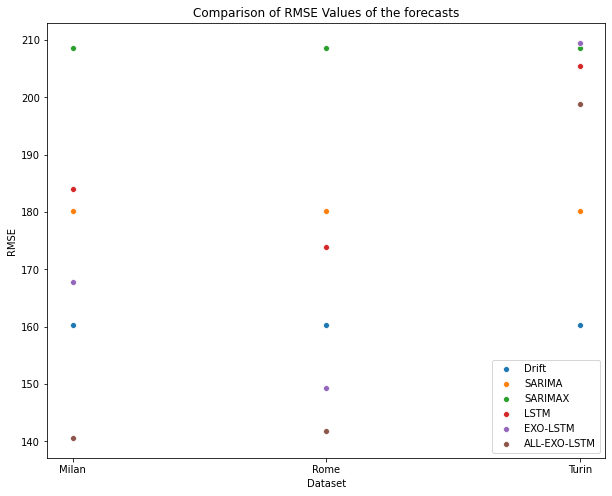

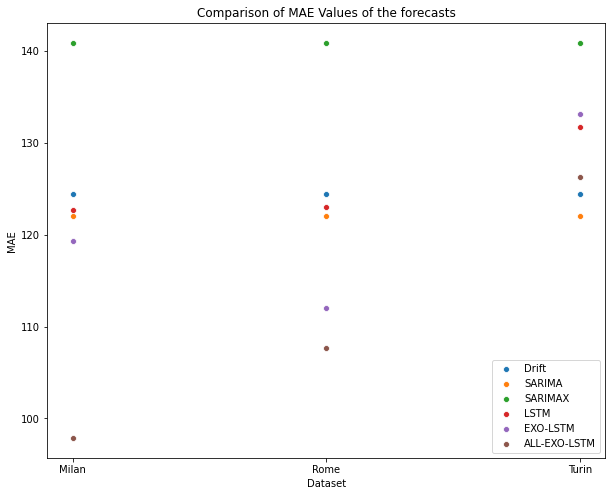

In [82]:
# Graphic comparison of error values: RMSE
plt.figure(figsize=(10,8))
plt.title("Comparison of RMSE Values of the forecasts")
ax = sns.scatterplot(x=mean_results.index, y="DRIFT RMSE", data=mean_results, label="Drift")
ax =sns.scatterplot(x=mean_results.index, y="ARIMA RMSE", data=mean_results, label="SARIMA")
ax = sns.scatterplot(x=mean_results.index, y="ARIMAX RMSE", data=mean_results, label="SARIMAX")
ax = sns.scatterplot(x=mean_results.index, y="LSTM RMSE", data=mean_results, label="LSTM")
ax = sns.scatterplot(x=mean_results.index, y="EXO-LSTM RMSE", data=mean_results, label="EXO-LSTM")
ax = sns.scatterplot(x=mean_results.index, y="ALL-EXO-LSTM RMSE", data=mean_results, label="ALL-EXO-LSTM")
ax.set(ylabel="RMSE")
plt.show()

# Graphic comparison of error values: MAE
plt.figure(figsize=(10,8))
plt.title("Comparison of MAE Values of the forecasts")
aax = sns.scatterplot(x=mean_results.index, y="DRIFT MAE", data=mean_results, label="Drift")
aax = sns.scatterplot(x=mean_results.index, y="ARIMA MAE", data=mean_results, label="SARIMA")
aax = sns.scatterplot(x=mean_results.index, y="ARIMAX MAE", data=mean_results, label="SARIMAX")
aax = sns.scatterplot(x=mean_results.index, y="LSTM MAE", data=mean_results, label="LSTM")
aax = sns.scatterplot(x=mean_results.index, y="EXO-LSTM MAE", data=mean_results, label="EXO-LSTM")
aax = sns.scatterplot(x=mean_results.index, y="ALL-EXO-LSTM MAE", data=mean_results, label="ALL-EXO-LSTM")
aax.set(ylabel="MAE")
plt.show()